In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from feature_decomp import Monomial
from kernels import GaussianKernel, ExponentialKernel, LaplaceKernel
from utils import ensure_torch, ensure_numpy, Hyperparams

kerneltype_dict = {
    "GaussianKernel": GaussianKernel,
    "ExponentialKernel": ExponentialKernel,
    "LaplaceKernel": LaplaceKernel,
}

In [2]:
hypers = Hyperparams(
    expt_name = "verify-hehe",
    dataset = "imagenet32",
    kernel_name = "GaussianKernel",
    kernel_width = 4,
    n_samples = 20_000,
    p_modes = 10_000,
    # If using synth data, set these
    data_dim = 200,
    data_eigval_exp = 1.2,
    # If using natural image data, set these
    zca_strength = 0,
)

In [11]:
# SETUP FILE MANAGEMENT
#######################

exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", hypers.expt_name, hypers.dataset)
expt_dir = os.path.join(expt_dir, hypers.generate_filepath())

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [12]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

result = expt_fm.load("result.pickle")

monomials = result["monomials"]
degrees = np.array([Monomial(m).degree() for m in monomials])

eigvecs = ensure_torch(expt_fm.load("kernel.pickle")["eigvecs"])
H = ensure_torch(expt_fm.load("H.npy"))
_, P_modes = H.shape
M = (eigvecs[:, :P_modes].T @ H)**2
M = ensure_numpy(M)

fra_eigvals = result["th_eigvals"]
emp_eigvals = result["emp_eigvals"]
d_eff = result["d_eff"]

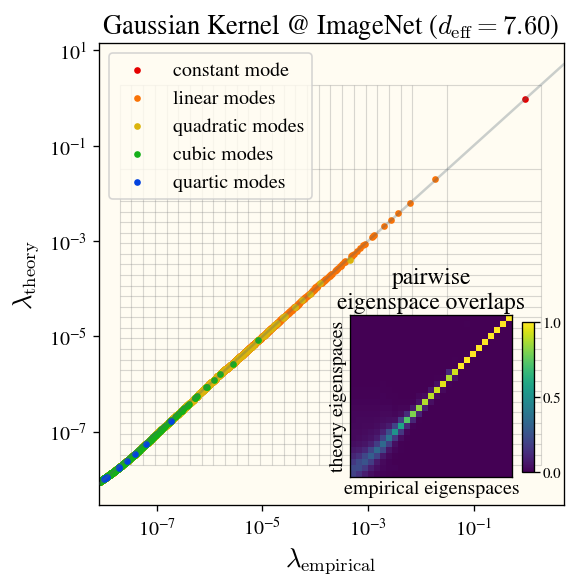

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# plot_title = f"$d_\mathrm{{eff}}={d_eff:.2f}$, $\sigma={kernel_width}$, {kernelname}"
plot_title = f"Gaussian Kernel @ ImageNet ($d_\mathrm{{eff}}={d_eff:.2f}$)"
ax.set_title(plot_title, fontsize=16)

xmin = 1
for degree in np.unique(degrees):
    if degree > 5:
        continue
    label = ["constant", "linear", "quadratic", "cubic", "quartic", "quintic"][degree]
    label += " mode" if degree==0 else " modes"
    idxs = np.where(np.array(degrees) == degree)[0]
    ax.scatter(emp_eigvals[idxs], fra_eigvals[idxs],
               color=colors[degree%7], marker='.', label=label)
    xmin = min(xmin, emp_eigvals[idxs].min())

xmax = 5e0
xx = np.linspace(xmin, xmax, 10)
ax.set_xlim(xmin, xmax)
ax.plot(xx, xx, color='xkcd:slate', alpha=0.3, zorder=4)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'$\lambda_\mathrm{{empirical}}$', fontsize=16)
ax.set_ylabel(f'$\lambda_\mathrm{{theory}}$', fontsize=16)
ax.legend(fontsize=12)

def add_partial_grid(ax, x_vals, y_vals, **line_kws):    
    xmin, xmax = x_vals.min(), x_vals.max()
    ymin, ymax = y_vals.min(), y_vals.max()
    
    ax.hlines(y_vals, xmin, xmax, **line_kws)
    ax.vlines(x_vals, ymin, ymax, **line_kws)

all_eigvals = np.concatenate([fra_eigvals, emp_eigvals[:P_modes]])
all_eigvals = all_eigvals[all_eigvals>0]
nbins = 36
bin_edges = []
lower_edge, upper_edge = max(2e-8, all_eigvals.min()), 2*all_eigvals.max()
for bin_edge in np.geomspace(lower_edge, upper_edge, num=(nbins+1)):
    if len(bin_edges) == 0:
        bin_edges.append(bin_edge)
        continue
    if ((bin_edge > fra_eigvals) & (fra_eigvals > bin_edges[-1])).any():
        bin_edges.append(bin_edge)
bin_edges[-1] = upper_edge
bin_edges = np.array(bin_edges)
nbins = len(bin_edges) - 1
    
fra_bins = np.digitize(fra_eigvals, bin_edges) - 1
emp_bins = np.digitize(emp_eigvals[:P_modes], bin_edges) - 1
M_coarse = np.zeros((nbins, nbins))
for mi in range(nbins):
    row_inds = np.where(fra_bins == mi)[0]
    for mj in range(nbins):
        col_inds = np.where(emp_bins == mj)[0]
        if len(row_inds) == 0 or len(col_inds) == 0:
            continue
        block = M[np.ix_(row_inds, col_inds)]
        M_coarse[mi, mj] = block.sum() / len(col_inds)

add_partial_grid(
    ax, bin_edges, bin_edges,
    color='grey', alpha=0.3, lw=0.7, ls='-', zorder=0
)

dpi = plt.rcParams['figure.dpi']
side_in = (M_coarse.shape[0]*6) / dpi

ax_inset = inset_axes(ax, width=side_in, height=side_in, loc="lower left",
    bbox_to_anchor=(0.52, 0.04, 1, 1),
    bbox_transform=ax.transAxes,
)
cbar = ax_inset.matshow(M_coarse, aspect='equal', interpolation='none', origin='lower', vmax=1, vmin=0)
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.tick_params(left=False, bottom=False)
ax_inset.set_xlabel("empirical eigenspaces", labelpad=2, fontsize=12)
ax_inset.set_ylabel("theory eigenspaces", labelpad=2, fontsize=12)
ax_inset.set_title("pairwise\neigenspace overlaps", pad=4, fontsize=14)

cax = fig.add_axes([0.83, 0.165, 0.02, 0.25])
cb = fig.colorbar(cbar, cax=cax)
cb.ax.set_yticks([0, 0.5, 1.0])
cb.ax.tick_params(labelsize=9, pad=2)

# plt.tight_layout()
plt.show()

# Old stuff

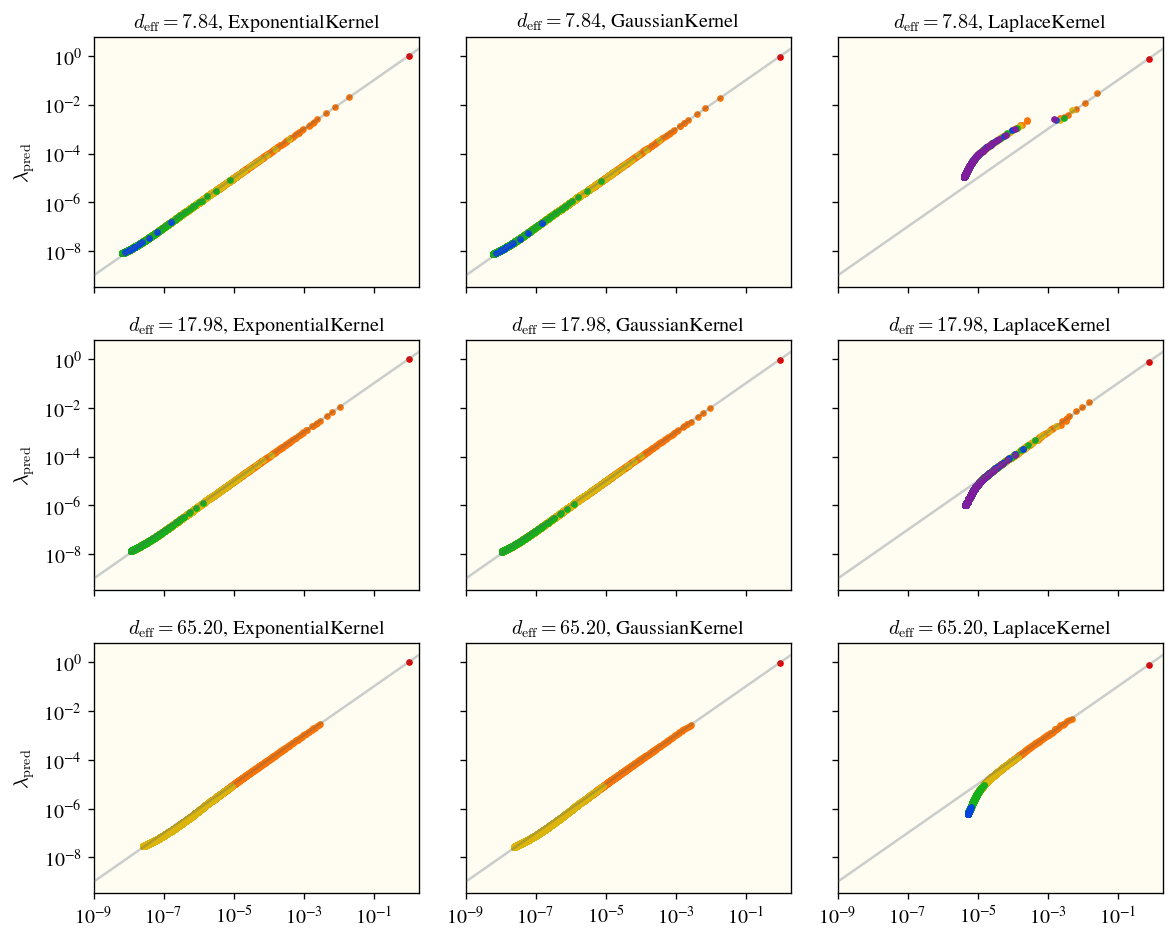

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
kernelnames = et_pathnames.get_axis("kernel")
d_effs = et_pathnames.get_axis("d_eff")
d_effs = d_effs[:3]

fig, axes = plt.subplots(nrows=len(d_effs), ncols=len(kernelnames),
                        figsize=(10, 8), sharex=True, sharey=True)

for i, d_eff in enumerate(d_effs):
    for j, kernelname in enumerate(kernelnames):
        subpath = et_pathnames[d_eff, kernelname]
        expt_fm.set_filepath(subpath)
        monomials = expt_fm.load("monomials.pickle")
        degrees = np.array([Monomial(m).degree() for m in monomials])
        
        fra_eigvals = et_fra_eigvals[d_eff, kernelname]
        emp_eigvals = et_emp_eigvals[d_eff, kernelname]

        ax = axes[i, j]
        ax.set_title(f'$d_\mathrm{{eff}}={d_eff:.2f}$, {kernelname}', fontsize=12)

        for degree in np.unique(degrees):
            if degree > 5:
                continue
            idxs = np.where(np.array(degrees) == degree)[0]
            ax.scatter(emp_eigvals[idxs], fra_eigvals[idxs],
                       color=colors[degree%7], marker='.')

        xmin, xmax = 1e-9, 2e0
        xx = np.linspace(xmin, xmax, 10)
        ax.set_xlim(xmin, xmax)
        ax.plot(xx, xx, color='xkcd:slate', alpha=0.3, zorder=4)
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 3:
            ax.set_xlabel(f'$\lambda_\mathrm{{emp}}$')
        if j == 0:
            ax.set_ylabel(f'$\lambda_\mathrm{{pred}}$')

plt.tight_layout()
plt.show()

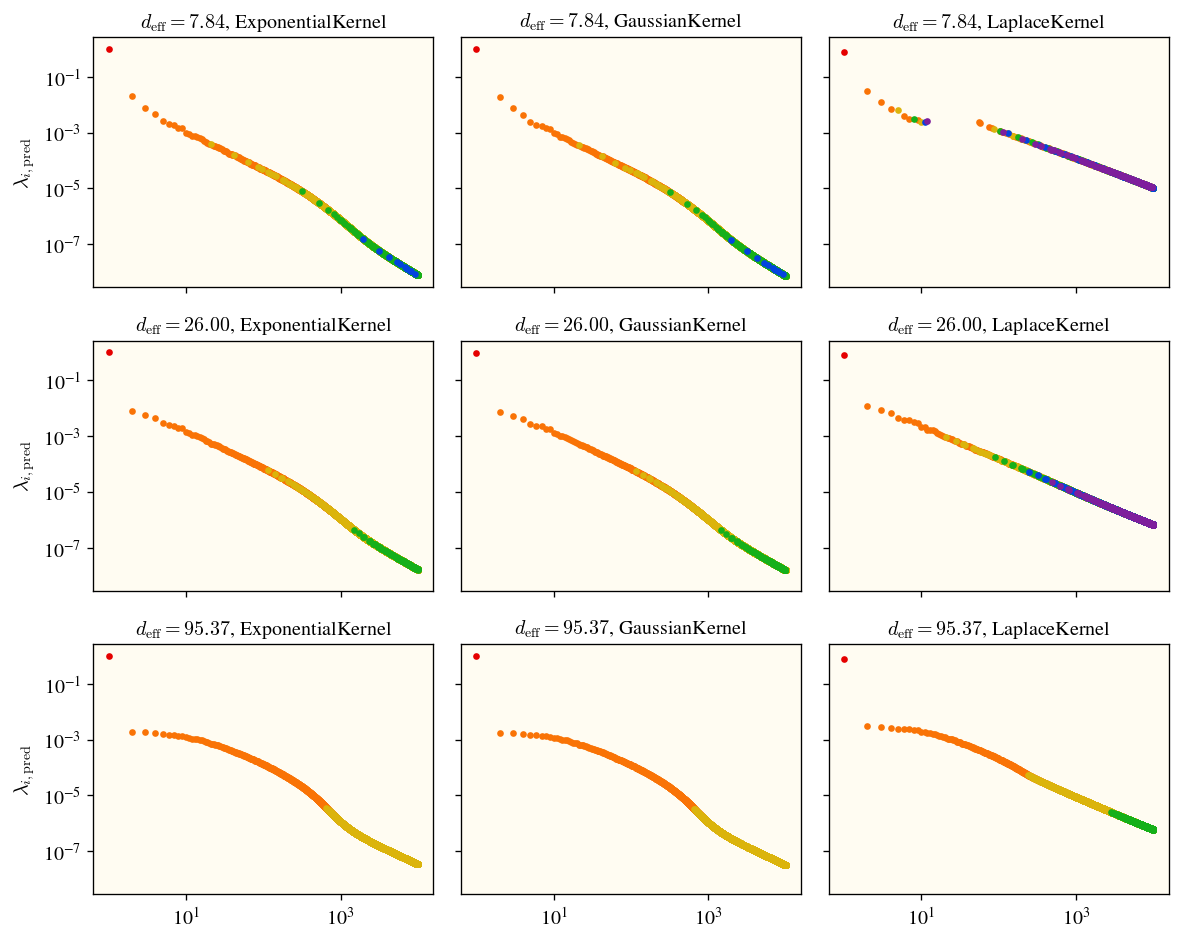

In [20]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
kerneltypes = et_pathnames.get_axis("kernel")
d_effs = et_pathnames.get_axis("d_eff")
d_effs = d_effs[:3]

fig, axes = plt.subplots(nrows=len(d_effs), ncols=len(kerneltypes),
                        figsize=(10, 8), sharex=True, sharey=True)

for i, d_eff in enumerate(d_effs):
    for j, kerneltype in enumerate(kerneltypes):
        subpath = et_pathnames[d_eff, kerneltype]
        expt_fm.set_filepath(subpath)
        monomials = expt_fm.load("monomials.pickle")
        degrees = np.array([Monomial(m).degree() for m in monomials])
        
        fra_eigvals = et_fra_eigvals[d_eff, kerneltype]
        emp_eigvals = et_emp_eigvals[d_eff, kerneltype]

        ax = axes[i, j]
        ax.set_title(f'$d_\mathrm{{eff}}={d_eff:.2f}$, {kerneltype}', fontsize=12)

        for degree in np.unique(degrees):
            if degree > 5:
                continue
            idxs = np.where(np.array(degrees) == degree)[0]
            ax.scatter(1+idxs, fra_eigvals[idxs],
                       color=colors[degree%7], marker='.')

        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 3:
            ax.set_xlabel(f'mode index $i$')
        if j == 0:
            ax.set_ylabel(f'$\lambda_{{i,\mathrm{{pred}}}}$')

plt.tight_layout()
plt.show()

...
...
...


/var/tmp/ipykernel_1757828/3045065816.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


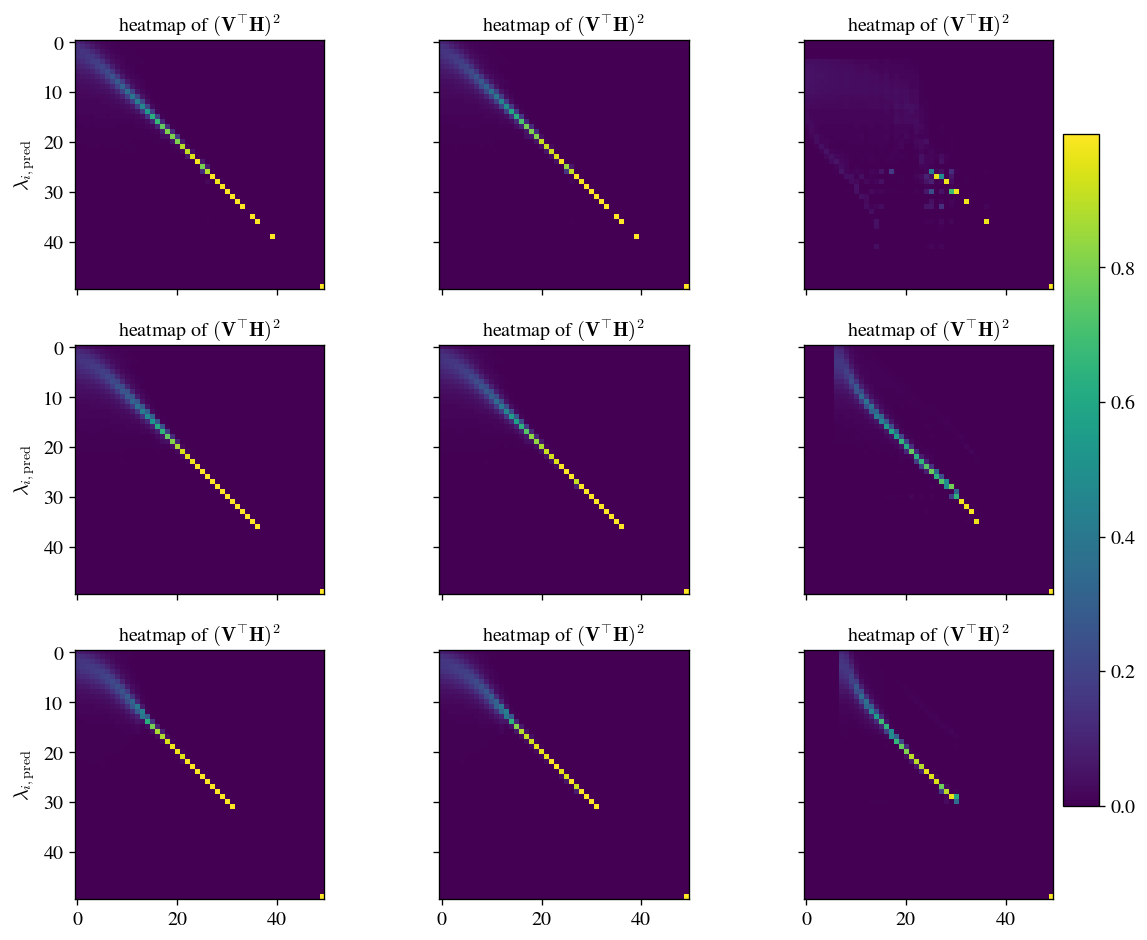

In [21]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
kernelnames = et_pathnames.get_axis("kernel")

d_effs = et_pathnames.get_axis("d_eff")
d_effs = d_effs[:3]

fig, axes = plt.subplots(nrows=len(d_effs), ncols=len(kernelnames),
                        figsize=(10, 8), sharex=True, sharey=True)

for i, d_eff in enumerate(d_effs):
    for j, kernelname in enumerate(kernelnames):
        print(".", end="")
        subpath = et_pathnames[d_eff, kernelname]
        expt_fm.set_filepath(subpath)
        kerneltype = kerneltype_dict[kernelname]
        kernel_data = expt_fm.load("kernel.pickle")
        eigvecs = ensure_torch(kernel_data["eigvecs"])
        del kernel_data
        H = ensure_torch(expt_fm.load("H.npy"))
        _, P_modes = H.shape
        M = (eigvecs[:, :P_modes].T @ H)**2
        del H
        M = ensure_numpy(M)
        
        fra_eigvals = et_fra_eigvals[d_eff, kernelname]
        emp_eigvals = et_emp_eigvals[d_eff, kernelname][:P_modes]
        
        all_eigvals = np.concatenate([fra_eigvals, emp_eigvals])
        all_eigvals = all_eigvals[all_eigvals>0]
        nbins = 50
        bin_edges = np.geomspace(max(1e-8, all_eigvals.min()), all_eigvals.max()+1e-5, num=(nbins+1))
        fra_bins = np.digitize(fra_eigvals, bin_edges) - 1
        emp_bins = np.digitize(emp_eigvals, bin_edges) - 1
        M_coarse = np.zeros((nbins, nbins))
        for mi in range(nbins):
            row_inds = np.where(fra_bins == mi)[0]
            for mj in range(nbins):
                col_inds = np.where(emp_bins == mj)[0]
                if len(row_inds) == 0 or len(col_inds) == 0:
                    continue
                block = M[np.ix_(row_inds, col_inds)]
                M_coarse[mi, mj] = block.sum() / len(col_inds)

        ax = axes[i, j]
        cbar = ax.imshow(M_coarse, aspect='equal', interpolation='nearest')
        ax.set_title(r'heatmap of $(\mathbf{V}^\top \mathbf{H})^2$', fontsize=12)
        
        if i == 3:
            ax.set_xlabel(f'mode index $i$')
        if j == 0:
            ax.set_ylabel(f'$\lambda_{{i,\mathrm{{pred}}}}$')
    print()

cax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
fig.colorbar(cbar, cax=cax)

plt.tight_layout()
plt.show()

In [19]:
import torch
torch.cuda.empty_cache()